In [1]:
import csv
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import json
import tsfel

import os
from os import listdir
from os.path import isfile, join

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [2]:
mypath = os.getcwd()
# mypath = mypath + "/IS708_api-with_hand_models/IS708_api/segments_train/"
mypath = mypath + "/segments_train/"
assert(os.path.isdir(mypath) == True)

all_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

label_l = []
for f in all_files:
    if "Nodding" in f:
        label_l.append(1)
    elif "Shaking" in f:
        label_l.append(2)
    else:
        label_l.append(0)
dataset = [(data, label_l[index]) for index, data in enumerate(all_files)]

In [3]:
# divide into train and test set
train, validation = train_test_split(dataset, test_size=0.1, random_state=27, shuffle=True)

In [4]:
label_l_train = [x[1] for x in train]
all_files = [x[0] for x in train]

len(label_l), len(all_files)

(462, 415)

In [5]:
label_train_df = pd.DataFrame(label_l_train, columns=['label'])
label_train_df.head()

,label
0,0
1,0
2,1
3,0
4,1


In [6]:
all_files[0:10]

['336_Null.csv',
 '55_Null.csv',
 '461_Nodding.csv',
 '370_Null.csv',
 '397_Nodding.csv',
 '398_Shaking.csv',
 '56_Null.csv',
 '148_Nodding.csv',
 '99_Shaking.csv',
 '246_Nodding.csv']

In [7]:
validation

[('400_Shaking.csv', 2),
 ('229_Shaking.csv', 2),
 ('54_Null.csv', 0),
 ('450_Null.csv', 0),
 ('470_Shaking.csv', 2),
 ('458_Null.csv', 0),
 ('393_Nodding.csv', 1),
 ('13_Null.csv', 0),
 ('58_Null.csv', 0),
 ('130_Null.csv', 0),
 ('405_Null.csv', 0),
 ('206_Null.csv', 0),
 ('85_Null.csv', 0),
 ('487_Null.csv', 0),
 ('300_Null.csv', 0),
 ('244_Nodding.csv', 1),
 ('359_Shaking.csv', 2),
 ('72_Null.csv', 0),
 ('427_Nodding.csv', 1),
 ('318_Shaking.csv', 2),
 ('234_Nodding.csv', 1),
 ('468_Shaking.csv', 2),
 ('102_Nodding.csv', 1),
 ('311_Null.csv', 0),
 ('456_Null.csv', 0),
 ('46_Null.csv', 0),
 ('29_Nodding.csv', 1),
 ('139_Shaking.csv', 2),
 ('125_Null.csv', 0),
 ('205_Null.csv', 0),
 ('340_Null.csv', 0),
 ('83_Null.csv', 0),
 ('386_Shaking.csv', 2),
 ('49_Null.csv', 0),
 ('338_Null.csv', 0),
 ('437_Nodding.csv', 1),
 ('122_Null.csv', 0),
 ('2_Null.csv', 0),
 ('303_Null.csv', 0),
 ('380_Null.csv', 0),
 ('443_Nodding.csv', 1),
 ('441_Nodding.csv', 1),
 ('28_Shaking.csv', 2),
 ('319_Noddi

# Preprocessing

In [8]:
# load data and scale data
df_l = []
for fname in all_files:
    data = {'ax':[], 'ay':[], 'az':[], 'gx':[], 'gy':[], 'gz':[]}
    with open(mypath+fname,'r') as csvfile:
        dp = csv.reader(csvfile, delimiter=',')
        next(dp, None)
        for row in dp:
            data['ax'].append(float(row[1]))
            data['ay'].append(float(row[2]))
            data['az'].append(float(row[3]))
            data['gx'].append(float(row[4]))
            data['gy'].append(float(row[5]))
            data['gz'].append(float(row[6]))
        df = pd.DataFrame.from_dict(data)
        df = df.iloc[:50,:]
        del df['ax']
        del df['ay']
        del df['az']
        df_l.append(df)

In [9]:
assert(len(df_l)==len(label_l_train))

In [10]:
df_l = [x.reindex(range(50), fill_value=0) for x in df_l]

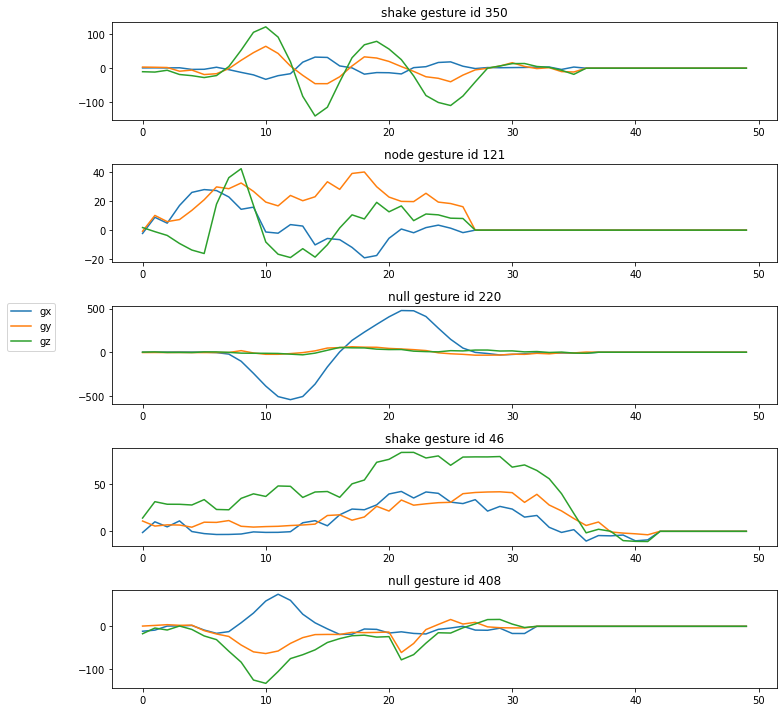

In [11]:
fig, axs = plt.subplots(5)
fig.set_figheight(10)
fig.set_figwidth(10)

for i, data in enumerate(random.sample(range(0,len(df_l)), 5)):
    df = df_l[data] 
    label = label_l[data]
    if label==1:
        label = "node"
    elif label==2:
        label = "shake"
    elif label==0:
        label = "null"
        
    axs[i].plot(df['gx'], label='gx')
    axs[i].plot(df['gy'], label='gy')
    axs[i].plot(df['gz'], label='gz')
    axs[i].title.set_text(f"{label} gesture id {data}")
#     axs[i].plot(df['ax'], label='ax')
#     axs[i].plot(df['ay'], label='ay')
#     axs[i].plot(df['az'], label='az')
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(-0.05,0.5))
fig.tight_layout()
plt.show()

# Extract Features

In [12]:
data_df = pd.concat(df_l, ignore_index=True)

In [13]:
isfile(os.getcwd() + "/classifier_model/config.json")

True

In [14]:
with open(os.getcwd() + "/classifier_model/config.json", 'r') as j:
    cfg_file = json.loads(j.read())

In [15]:
# initiate tsfel setup
fs=25
window_size=50
# cfg_file = tsfel.get_features_by_domain()    

# Get features
feature = tsfel.time_series_features_extractor(cfg_file, data_df, fs=fs, window_size=window_size)

*** Feature extraction started ***



*** Feature extraction finished ***


In [16]:
column_name = feature.columns

In [17]:
# Normalising Features
scaler = preprocessing.StandardScaler()
scaler.fit(feature)
feature = scaler.transform(feature)

In [18]:
feature_df = pd.DataFrame(feature, columns=column_name)

In [19]:
model = RandomForestClassifier()
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
acc_l = []

# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier(random_state=0)

# from sklearn.svm import SVC
# model = SVC(kernel='linear')

for train_index, test_index in skf.split(feature_df, label_train_df):
    x_train = feature_df.iloc[train_index, :]
    x_test = feature_df.iloc[test_index, :]
    y_train = label_train_df.iloc[train_index, 0]
    y_test = label_train_df.iloc[test_index, 0]
    
    model.fit(x_train, y_train)
    pred_values = model.predict(x_test)
    
    acc = accuracy_score(y_test, pred_values)
    acc_l.append(acc)

avg_score = sum(acc_l)/len(acc_l)

# print(f"acc list: {acc_l}")
print(f"average acc is {avg_score}")

average acc is 0.9566781357522678


In [20]:
print(classification_report(y_test, pred_values, target_names=['null', 'node', 'shake']))

              precision    recall  f1-score   support

        null       1.00      0.96      0.98        73
        node       0.97      1.00      0.98        32
       shake       0.94      1.00      0.97        33

    accuracy                           0.98       138
   macro avg       0.97      0.99      0.98       138
weighted avg       0.98      0.98      0.98       138



In [21]:
# # model = RandomForestClassifier()
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
# acc_l = []

# # from sklearn.tree import DecisionTreeClassifier
# # model = DecisionTreeClassifier(random_state=0)

# from sklearn.svm import SVC
# model = SVC(kernel='linear')

# for train_index, test_index in skf.split(feature_df, label_df):
#     x_train = feature_df.iloc[train_index, :]
#     x_test = feature_df.iloc[test_index, :]
#     y_train = label_df.iloc[train_index, 0]
#     y_test = label_df.iloc[test_index, 0]
    
#     model.fit(x_train, y_train)
#     pred_values = model.predict(x_test)
    
#     acc = accuracy_score(y_test, pred_values)
#     acc_l.append(acc)

# avg_score = sum(acc_l)/len(acc_l)

# # print(f"acc list: {acc_l}")
# print(f"average acc is {avg_score}")

In [22]:
# print(classification_report(y_test, pred_values, target_names=['null', 'node', 'shake']))

In [23]:
# # model = RandomForestClassifier()
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
# acc_l = []

# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier(random_state=0)

# # from sklearn.svm import SVC
# # model = SVC(kernel='linear')

# for train_index, test_index in skf.split(feature_df, label_df):
#     x_train = feature_df.iloc[train_index, :]
#     x_test = feature_df.iloc[test_index, :]
#     y_train = label_df.iloc[train_index, 0]
#     y_test = label_df.iloc[test_index, 0]
    
#     model.fit(x_train, y_train)
#     pred_values = model.predict(x_test)
    
#     acc = accuracy_score(y_test, pred_values)
#     acc_l.append(acc)

# avg_score = sum(acc_l)/len(acc_l)

# # print(f"acc list: {acc_l}")
# print(f"average acc is {avg_score}")

In [24]:
# print(classification_report(y_test, pred_values, target_names=['null', 'node', 'shake']))

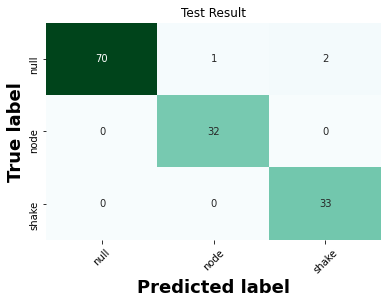

In [25]:
# title Confusion Matrix
cm = confusion_matrix(y_test, pred_values)
df_cm = pd.DataFrame(cm, index=[i for i in ['null', 'node', 'shake']], columns=[i for i in ['null', 'node', 'shake']])
plt.figure()
ax= sns.heatmap(df_cm,  cbar=False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.title("Test Result")
plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
bottom, top = ax.get_ylim()
plt.show()

In [26]:
# filename = 'gesture_clf'
# pickle.dump(model, open(filename, 'wb'))

# filename = "scaler"
# pickle.dump(scaler, open(filename, 'wb'))

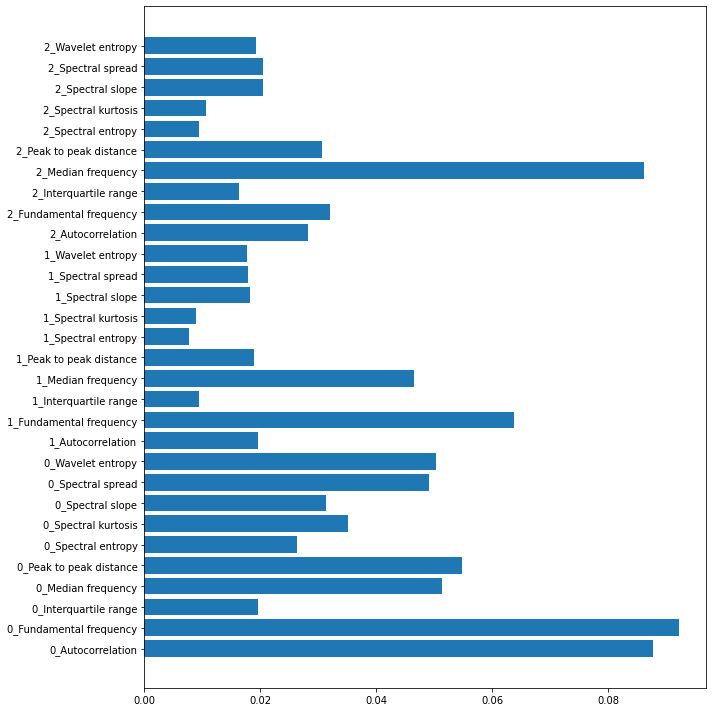

In [27]:
plt.figure(figsize=(10,10))
plt.barh(column_name, model.feature_importances_)
plt.tight_layout()
plt.show()

# Validation

In [28]:
df_l = []
val_label_l = []
for fname, label in validation:
    data = {'ax':[], 'ay':[], 'az':[], 'gx':[], 'gy':[], 'gz':[]}
    with open(mypath+fname,'r') as csvfile:
        dp = csv.reader(csvfile, delimiter=',')
        next(dp, None)
        for row in dp:
            data['ax'].append(float(row[1]))
            data['ay'].append(float(row[2]))
            data['az'].append(float(row[3]))
            data['gx'].append(float(row[4]))
            data['gy'].append(float(row[5]))
            data['gz'].append(float(row[6]))
        df = pd.DataFrame.from_dict(data)
        df = df.iloc[:50,:]
        del df['ax']
        del df['ay']
        del df['az']
        df_l.append(df)
        val_label_l.append(label)
    
# pred_values = model.predict(x_test)

In [29]:
# df.shape[0]

In [30]:
df_l = [x.reindex(range(50), fill_value=0) for x in df_l]
validation_df = pd.concat(df_l, ignore_index=True)

fs=25
window_size=50

val_feature = tsfel.time_series_features_extractor(cfg_file, validation_df, fs=fs, window_size=window_size)
# val_feature.drop(corr_features, axis=1, inplace=True)
val_feature = scaler.transform(val_feature)

pred_values = model.predict(val_feature)
acc = accuracy_score(val_label_l, pred_values)
f1 = f1_score(val_label_l, pred_values, average=None)

print(f"acc: {acc}, f1: {f1}")

*** Feature extraction started ***



*** Feature extraction finished ***
acc: 0.9574468085106383, f1: [0.96153846 0.9        1.        ]


In [31]:
print(classification_report(val_label_l, pred_values, target_names=['null', 'node', 'shake']))

              precision    recall  f1-score   support

        null       0.96      0.96      0.96        26
        node       0.90      0.90      0.90        10
       shake       1.00      1.00      1.00        11

    accuracy                           0.96        47
   macro avg       0.95      0.95      0.95        47
weighted avg       0.96      0.96      0.96        47



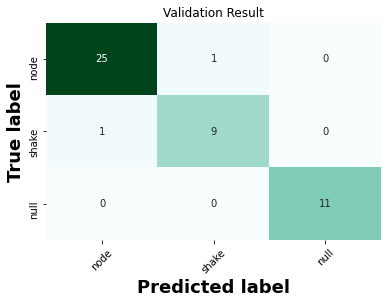

In [32]:
cm = confusion_matrix(val_label_l, pred_values)
df_cm = pd.DataFrame(cm, index=[i for i in ['node', 'shake', 'null']], columns=[i for i in ['node', 'shake', 'null']])
plt.figure()
ax= sns.heatmap(df_cm,  cbar=False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.title("Validation Result")
plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
bottom, top = ax.get_ylim()
plt.show()